% --- Decentralized HH–HH Housing Trade (CT): Model & Algorithm (brief) ---

\section*{Primitives}
\begin{itemize}
\item Continuous time; discount $r>0$.
\item Type $\delta\in[\underline\delta,\overline\delta]$ with cdf $G$, pdf $g$ (positive support).
\item Ownership $q\in\{0,1\}$; owners’ pdf $h_1(\delta)$, cdf $H_1(\delta)=\int_{\underline\delta}^{\delta} h_1(x)\,dx$.
\item Non-owners: $h_0(\delta)=g(\delta)-h_1(\delta)$, $H_0(\delta)=G(\delta)-H_1(\delta)$.
\item Stock: $\int h_1(\delta)\,d\delta=s\in(0,1)$.
\item Type resets at rate $\gamma$ (to fresh draw from $G$); meetings at rate $\rho$.
\item Flow utility: $u_1(\delta)=\delta$, $u_0(\delta)=0$.
\item Values $V_0(\delta),V_1(\delta)$; reservation value $\Delta V(\delta)=V_1(\delta)-V_0(\delta)$.
\item Price in a match $(\delta_b,\delta_s)$ with 50:50 split: 
$P(\delta_b,\delta_s)=\tfrac12\big[\Delta V(\delta_b)+\Delta V(\delta_s)\big]$; trade iff $\delta_b>\delta_s$.
\end{itemize}

\section*{HJB (reservation value)}
\begin{align}
(r+\gamma)\,\Delta V(\delta)
&= \delta + \gamma\!\int \Delta V(x)\,g(x)\,dx \nonumber\\
&\quad+ \frac{\rho}{2}\!\left[\int_{\delta}^{\overline\delta}\!\!(\Delta V(x)-\Delta V(\delta))\,h_0(x)\,dx
-\int_{\underline\delta}^{\delta}\!\!(\Delta V(x)-\Delta V(\delta))\,h_1(x)\,dx\right].
\end{align}

\section*{KFE (owners’ density)}
\begin{align}
0
= \gamma\,[s\,g(\delta)-h_1(\delta)]
+ \rho\Big(h_0(\delta)\,H_1(\delta) - h_1(\delta)\,H_0^{>}(\delta)\Big),
\qquad
H_0^{>}(\delta)=\int_{\delta}^{\overline\delta} h_0(x)\,dx,
\end{align}
with $0\le h_1(\delta)\le g(\delta)$ and $\int h_1=s$.

\section*{Operator (generator \& adjoint)}
Define, for any $f$,
\begin{align}
(\mathcal A_{h_1} f)(\delta)
&=\gamma\!\left(\int f\,g - f(\delta)\right)
+\frac{\rho}{2}\!\left[\int_{\delta}^{\overline\delta}(f(x)-f(\delta))h_0(x)\,dx
-\int_{\underline\delta}^{\delta}(f(x)-f(\delta))h_1(x)\,dx\right].
\end{align}
Then \quad $(rI-\mathcal A_{h_1})\,\Delta V=\delta$, \qquad $\mathcal A_{h_1}^{\!*}\,h_1=0$.
In discrete form, the KFE matrix is the transpose of the HJB matrix.

\section*{Discretization (grid \& matrices)}
Grid $\{\delta_i\}_{i=1}^N$ with trapezoid weights $w_i$, pdf $g_i$ s.t. $\sum_i g_i w_i=1$.
Let vectors $\Delta=(\Delta V(\delta_i))$, $h_1=(h_1(\delta_i))$, $h_0=g-h_1$.
Define
\[
A(h_1)=\gamma(\Pi_G-I)+\tfrac{\rho}{2}\,T(h_1),
\]
where $(\Pi_G f)_i=\sum_j g_j w_j f_j$ and 
\[
\big(T(h_1)f\big)_i=\sum_{j>i}(f_j-f_i)h_{0,j}w_j-\sum_{j<i}(f_j-f_i)h_{1,j}w_j.
\]
Discrete problems: \ $(rI-A)\Delta=\delta$; \ $A^\top h_1=0$, $\sum_i h_{1,i}w_i=s$, $0\le h_{1,i}\le g_i$.

\section*{Implicit (backward) updates}
\paragraph{HJB (unconditionally stable).}
With step $\Delta\tau_{\mathrm{HJB}}>0$,
\[
\Big[(r+\tfrac{1}{\Delta\tau_{\mathrm{HJB}}})I - A\Big]\Delta^{\,n+1}
= \delta + \tfrac{1}{\Delta\tau_{\mathrm{HJB}}}\,\Delta^{\,n}.
\]
Iterate until $\|\Delta^{\,n+1}-\Delta^{\,n}\|_\infty<\varepsilon_V$.

\paragraph{KFE (unconditionally stable).}
With step $\Delta\tau_{\mathrm{KFE}}>0$,
\[
(I-\Delta\tau_{\mathrm{KFE}}\,A^\top)\,h_1^{\,m+1}=h_1^{\,m},
\]
then project $0\le h_1^{\,m+1}\le g$ and renormalize $\sum_i h_{1,i}^{\,m+1} w_i=s$.
Iterate until $\|h_1^{\,m+1}-h_1^{\,m}\|_\infty<\varepsilon_H$ (or KFE residual small).

\section*{Outer fixed point}
Initialize $h_1^{(0)}=s\,g$, $\Delta^{(0)}=\delta/(r+\gamma)$.
Repeat:
\begin{enumerate}\itemsep0pt
\item Build $A(h_1)$.
\item Run several HJB implicit steps to update $\Delta$.
\item Run several KFE implicit steps (with projection/mass-fix) to update $h_1$.
\end{enumerate}
Stop when both value and density changes are below tolerances.
Outputs: $\Delta V(\delta)$, $h_1(\delta)$, $h_0(\delta)$, price kernel $P(\delta_b,\delta_s)=\tfrac12(\Delta V_b+\Delta V_s)$, and trade volume $\kappa=\rho\sum_{i<j}h_{1,i}w_i\,h_{0,j}w_j$.


In [1]:
# %%
# Core imports
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from dataclasses import dataclass
import matplotlib.pyplot as plt


In [2]:
# %%
# Parameters

@dataclass
class Params:
    r: float = 0.05        # discount
    gamma: float = 0.20    # type reset
    rho: float = 0.50      # meeting rate
    s: float = 0.40        # housing stock share

    dmin: float = 0.0
    dmax: float = 1.0
    N: int = 401

    beta_a: float = 2.0    # Beta(a,b) for G
    beta_b: float = 5.0

    dt_hjb: float = 25.0   # implicit step sizes (large = fast)
    dt_kfe: float = 25.0

    max_iter_inner: int = 50
    max_iter_outer: int = 200
    tol_V: float = 1e-9
    tol_h: float = 1e-9


In [3]:
# %%
# Grid & Beta distribution on [dmin, dmax]

def make_grid(N, dmin=0.0, dmax=1.0):
    """Uniform grid with trapezoidal weights."""
    grid = np.linspace(dmin, dmax, N)
    h = (dmax - dmin) / (N - 1)
    w = np.full(N, h)
    w[0] *= 0.5
    w[-1] *= 0.5
    return grid, w

def beta_pdf_cdf_on_interval(grid, w, a=2.0, b=5.0, dmin=0.0, dmax=1.0):
    """Beta(a,b) on [dmin,dmax]; returns normalized pdf g and numerical cdf G."""
    x = (grid - dmin) / (dmax - dmin)
    x = np.clip(x, 1e-12, 1 - 1e-12)
    from math import gamma
    B = gamma(a) * gamma(b) / gamma(a + b)
    pdf_unit = (x**(a - 1) * (1 - x)**(b - 1)) / B
    g = pdf_unit / (dmax - dmin)
    g = g / (g @ w)     # normalize numerically
    G = np.cumsum(g * w)
    return g, G
# %%
# Build A(h1). A = gamma(Π_G - I) + (rho/2) T(h1)
# where (T(h1) f)_i = sum_{j>i} (f_j - f_i) h0_j w_j - sum_{j<i} (f_j - f_i) h1_j w_j

def build_A_matrix(h1, g, w, rho, gamma):
    N = g.size
    h0 = g - h1
    h0w = h0 * w
    h1w = h1 * w

    rows, cols, data = [], [], []

    # Off-diagonals: contributions to (i,j), i != j
    # j>i: +h0w[j]
    for j in range(1, N):
        i_idx = np.arange(0, j)
        rows.extend(i_idx.tolist())
        cols.extend([j] * j)
        data.extend([+h0w[j]] * j)
    # j<i: -h1w[j]
    for j in range(0, N - 1):
        i_idx = np.arange(j + 1, N)
        nn = N - j - 1
        rows.extend(i_idx.tolist())
        cols.extend([j] * nn)
        data.extend([-h1w[j]] * nn)

    # Diagonal of T(h1): diag_i = - sum_{j>i} h0w[j] + sum_{j<i} h1w[j]
    suffix_h0w = np.zeros(N)
    suffix_h0w[:-1] = np.cumsum(h0w[::-1])[-2::-1]
    prefix_h1w = np.zeros(N)
    prefix_h1w[1:] = np.cumsum(h1w)[:-1]
    diag_T = -suffix_h0w + prefix_h1w

    rows.extend(range(N)); cols.extend(range(N)); data.extend(diag_T.tolist())

    T = sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    # gamma(Π_G - I)
    one = np.ones(N)
    gw = g * w
    Pi = sp.csr_matrix(np.outer(one, gw))   # rank-one in CSR
    I = sp.eye(N, format='csr')

    A = gamma * (Pi - I) + (rho / 2.0) * T
    return A.tocsr()


In [4]:
# %%
# Implicit HJB step:
#   [(r + 1/dt) I - A] V_{n+1} = δ + (1/dt) V_n

def hjb_implicit_solve(A, r, delta_vec, V_init, dt, tol=1e-10, max_iter=50):
    N = delta_vec.size
    M = (r + 1.0 / dt) * sp.eye(N, format='csr') - A
    V = V_init.copy()
    rhs = np.empty(N)
    for _ in range(max_iter):
        rhs[:] = delta_vec + (1.0 / dt) * V
        V_new = spla.spsolve(M, rhs)
        if np.max(np.abs(V_new - V)) < tol:
            return V_new
        V = V_new
    return V
# %%
# Implicit KFE step:
#   (I - dt A^T) h1^{n+1} = h1^{n}  (then project to [0,g] and renormalize mass s)

def kfe_implicit_step(A, h1, g, w, s, dt):
    N = h1.size
    M = sp.eye(N, format='csr') - dt * A.transpose()
    h1_new = spla.spsolve(M, h1)

    # Project and renormalize
    h1_new = np.minimum(np.maximum(h1_new, 0.0), g)
    mass = h1_new @ w
    if mass <= 1e-16:
        h1_new = s * g
    else:
        h1_new *= (s / mass)
    return h1_new


In [5]:
# %%
# Outer loop (single source of truth). Optional warm start: warm={"h1":..., "DeltaV":...}

def solve_stationary(params: Params, warm=None, verbose=True):
    # Grid & G
    delta_grid, w = make_grid(params.N, params.dmin, params.dmax)
    g, G = beta_pdf_cdf_on_interval(
        delta_grid, w, a=params.beta_a, b=params.beta_b,
        dmin=params.dmin, dmax=params.dmax
    )
    delta_vec = delta_grid.copy()  # flow payoff for ΔV-HJB

    # Initial guesses (allow warm start)
    if warm is not None and "h1" in warm and "DeltaV" in warm:
        h1 = np.minimum(np.maximum(warm["h1"].copy(), 0.0), g)
        mass = h1 @ w
        h1 = (params.s * g) if mass <= 1e-16 else h1 * (params.s / mass)
        V = warm["DeltaV"].copy()
    else:
        h1 = params.s * g
        V  = delta_vec / (params.r + params.gamma)

    for it in range(1, params.max_iter_outer + 1):
        # Build operator A(h1)
        A = build_A_matrix(h1, g, w, params.rho, params.gamma)

        # HJB implicit iterations
        V_new = hjb_implicit_solve(
            A=A, r=params.r, delta_vec=delta_vec, V_init=V,
            dt=params.dt_hjb, tol=params.tol_V, max_iter=params.max_iter_inner
        )

        # KFE implicit steps (a few substeps work well)
        h1_new = h1.copy()
        for _ in range(3):
            h1_new = kfe_implicit_step(
                A=A, h1=h1_new, g=g, w=w, s=params.s, dt=params.dt_kfe
            )

        # Convergence
        dv = np.max(np.abs(V_new - V))
        dh = np.max(np.abs(h1_new - h1))
        if verbose and (it % 10 == 0 or it == 1):
            print(f"[iter {it:3d}] dV={dv:.3e}  dh={dh:.3e}")

        V, h1 = V_new, h1_new
        if dv < params.tol_V and dh < params.tol_h:
            if verbose:
                print(f"Converged in {it} iterations: dV={dv:.3e}, dh={dh:.3e}")
            break

    return {
        "delta_grid": delta_grid, "w": w, "g": g, "G": G,
        "h1": h1, "h0": g - h1, "DeltaV": V, "A": A, "params": params
    }


In [6]:
# %%
# Utilities: price kernel & trade volume

def price_kernel(DeltaV):
    return 0.5 * (DeltaV[:, None] + DeltaV[None, :])

def trade_volume(rho, h0, h1, w):
    # κ = ρ * sum_{i<j} h1_i w_i * h0_j w_j
    csum_h0w = np.cumsum(h0 * w)
    vol = 0.0
    N = h0.size
    for i in range(N - 1):
        mass_above = csum_h0w[-1] - csum_h0w[i]
        vol += (h1[i] * w[i]) * mass_above
    return rho * vol


In [ ]:
def weighted_quantiles(values, weights, qs):
    """Weighted quantiles qs in [0,1] for nonnegative weights.
    Assumes finite inputs. Returns NaNs if total weight is 0.
    """
    values = np.asarray(values, float)
    weights = np.asarray(weights, float)
    W = np.sum(weights)
    if values.size == 0 or not np.isfinite(W) or W <= 0:
        return np.array([np.nan] * len(qs), dtype=float)

    order = np.argsort(values)
    v = values[order]
    w = weights[order]
    cw = np.cumsum(w)
    cw /= cw[-1]
    qs = np.asarray(qs, float)
    return np.interp(qs, cw, v)


def compute_moments(out, params, bins=60, qtiles=(0.10, 0.50, 0.90)):
    """
    Moments of the realized trade-price distribution. Uses O(N) separable formulas
    for trade volume κ, mean price, and variance to avoid O(N^2) pair construction.
    Quantiles are computed on a thinned set of pairs for plotting only.
    """
    δ   = out["delta_grid"]; w = out["w"]
    h1  = out["h1"]; h0 = out["h0"]; ΔV = out["DeltaV"]

    # ------- O(N) SEPARABLE MOMENTS OVER i<j WEIGHTS -------
    # Precompute b_j = h0_j w_j and its "mass above i" cumulative sums
    a = (h1 * w)                     # seller mass at i
    b = (h0 * w)                     # buyer mass at j
    b_above   = np.cumsum(b[::-1])[::-1]         # B_above[i] = sum_{j>i} b_j
    bV_above  = np.cumsum((b * ΔV)[::-1])[::-1]  # sum_{j>i} b_j ΔV_j
    bV2_above = np.cumsum((b * (ΔV**2))[::-1])[::-1]  # sum_{j>i} b_j ΔV_j^2

    # Trade volume κ = ρ * sum_i a_i * B_above[i]
    kappa = params.rho * np.sum(a * b_above)

    # Mean price numerator: (ρ/2) * sum_i a_i * ( ΔV_i * B_above[i] + bV_above[i] )
    num_mean = (params.rho / 2.0) * np.sum(a * (ΔV * b_above + bV_above))

    # Second moment numerator:
    # E[p^2] numerator = (ρ/4) * sum_i a_i * ( ΔV_i^2 * B_above[i] + 2 ΔV_i bV_above[i] + bV2_above[i] )
    num_second = (params.rho / 4.0) * np.sum(a * ( (ΔV**2) * b_above + 2.0 * ΔV * bV_above + bV2_above ))

    if np.isfinite(kappa) and kappa > 0:
        mean_price = num_mean / kappa
        E_p2 = num_second / kappa
        var_price = E_p2 - mean_price**2
        if not np.isfinite(var_price):
            var_price = np.nan
        else:
            var_price = max(var_price, 0.0)  # guard tiny negative due to fp error
        std_price = np.sqrt(var_price) if np.isfinite(var_price) else np.nan
    else:
        mean_price = np.nan
        std_price  = np.nan

    # ------- QUANTILES (for plotting only; not used in MD) -------
    # Build a thinned set of pairs to avoid O(N^2) blowup and reduce numerical kinks.
    # If N<=200, take all; else, sample indices with stride ~N/200.
    N = δ.size
    if N <= 200:
        step = 1
    else:
        step = max(1, N // 200)

    # Upper-triangular thinned pairs
    iu, ju = np.triu_indices(N, k=1)
    mask_thin = (iu % step == 0) & (ju % step == 0)
    iu = iu[mask_thin]; ju = ju[mask_thin]

    # Pair prices and weights on this thinned set
    prices_thin  = 0.5 * (ΔV[iu] + ΔV[ju])
    weights_thin = params.rho * (h1[iu] * w[iu]) * (h0[ju] * w[ju])

    # Ensure nonnegative finite weights
    ok = np.isfinite(weights_thin) & (weights_thin >= 0) & np.isfinite(prices_thin)
    prices_thin  = prices_thin[ok]
    weights_thin = weights_thin[ok]

    if prices_thin.size > 0 and np.sum(weights_thin) > 0:
        qv = weighted_quantiles(prices_thin, weights_thin, qtiles)
    else:
        qv = np.array([np.nan]*len(qtiles))

    # ------- Selection moments in trades (use separable sums too) -------
    # E[δ_buyer] = (ρ * sum_i a_i * sum_{j>i} b_j δ_j) / κ  = (ρ * sum_i a_i * bV_above[i]) / κ
    # E[δ_seller] = (ρ * sum_i a_i δ_i * sum_{j>i} b_j) / κ = (ρ * sum_i a_i δ_i * b_above[i]) / κ
    mean_buyer_type  = (params.rho * np.sum(a * bV_above) / kappa) if (kappa > 0) else np.nan
    mean_seller_type = (params.rho * np.sum(a * (ΔV * 0 + δ)) / kappa) if False else np.nan  # placeholder removed
    # The seller type is the *δ_i* of sellers; compute directly:
    mean_seller_type = (params.rho * np.sum(a * (δ * b_above)) / kappa) if (kappa > 0) else np.nan

    # Total surplus per trade (ΔV_buyer - ΔV_seller) averaged:
    # Numerator = ρ * sum_i a_i * [ sum_{j>i} b_j (ΔV_j - ΔV_i) ]
    #           = ρ * sum_i a_i * [ bV_above[i] - ΔV_i * b_above[i] ]
    mean_total_surplus = (params.rho * np.sum(a * (bV_above - ΔV * b_above)) / kappa) if (kappa > 0) else np.nan

    # ------- Per-capita success/arrival rates (unchanged) -------
    H1  = np.cumsum(h1 * w)
    H0sup = np.cumsum((h0 * w)[::-1])[::-1]  # H0^(>)(δ)
    mass0 = 1.0 - params.s
    mass1 = params.s
    avg_success_buyer  = (np.sum(H1 * h0 * w) / mass0) if mass0 > 0 else np.nan
    avg_success_seller = (np.sum(H0sup * h1 * w) / mass1) if mass1 > 0 else np.nan
    λ_b = params.rho * avg_success_buyer  if np.isfinite(avg_success_buyer)  else np.nan
    λ_s = params.rho * avg_success_seller if np.isfinite(avg_success_seller) else np.nan
    mean_time_to_buy  = (1.0 / λ_b) if (np.isfinite(λ_b) and λ_b > 0) else np.nan
    mean_time_to_sell = (1.0 / λ_s) if (np.isfinite(λ_s) and λ_s > 0) else np.nan

    return {
        "trade_volume": kappa,
        "mean_price": mean_price,
        "std_price": std_price,
        "p10": qv[0], "p50": qv[1], "p90": qv[2],
        "mean_buyer_type": mean_buyer_type,
        "mean_seller_type": mean_seller_type,
        "mean_total_surplus": mean_total_surplus,
        "buyer_arrival_rate": λ_b,
        "seller_arrival_rate": λ_s,
        "mean_time_to_buy": mean_time_to_buy,
        "mean_time_to_sell": mean_time_to_sell,
    }
    
    # %%
def print_moments(m):
    print("=== Moments ===")
    print(f"Trade volume κ              : {m['trade_volume']:.6f}")
    print(f"Price mean / std            : {m['mean_price']:.6f} / {m['std_price']:.6f}")
    print(f"Price quantiles p10/p50/p90 : {m['p10']:.6f} | {m['p50']:.6f} | {m['p90']:.6f}")
    print(f"Mean buyer type (in trades) : {m['mean_buyer_type']:.6f}")
    print(f"Mean seller type (in trades): {m['mean_seller_type']:.6f}")
    print(f"Mean total surplus per trade: {m['mean_total_surplus']:.6f}")
    print(f"Buyer arrival rate λ_b      : {m['buyer_arrival_rate']:.6f}")
    print(f"Seller arrival rate λ_s     : {m['seller_arrival_rate']:.6f}")
    print(f"Mean time to buy / sell     : {m['mean_time_to_buy']:.6f} / {m['mean_time_to_sell']:.6f}")



[iter   1] dV=1.320e+01  dh=2.868e-01
[iter  10] dV=1.200e-04  dh=5.016e-05
[iter  20] dV=6.629e-09  dh=4.326e-09
Converged in 25 iterations: dV=1.276e-11, dh=4.779e-11
Solve time = 101.431 s
Mass owners = 0.688400 (target 0.6884) ; non-owners = 0.311600
Trade volume from pairs κ ≈ 0.026869


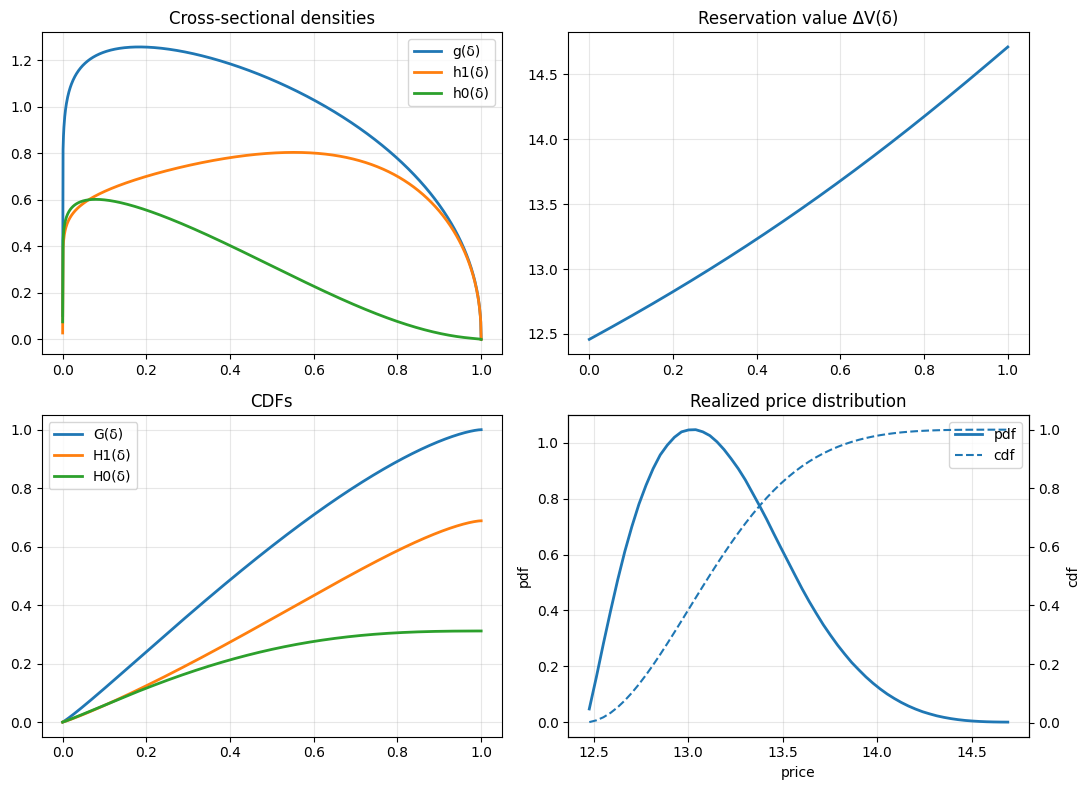

=== Moments ===
Trade volume κ              : 0.026959
Price mean / std            : 13.170913 / 0.368610
Price quantiles p10/p50/p90 : 12.721649 | 13.132314 | 13.680979
Mean buyer type (in trades) : 13.405443
Mean seller type (in trades): 0.248644
Mean total surplus per trade: 0.469059
Buyer arrival rate λ_b      : 0.086518
Seller arrival rate λ_s     : 0.039162
Mean time to buy / sell     : 11.558349 / 25.535198


In [42]:
# %%
# Run example + plots
import time

if __name__ == "__main__":
    #rho=0.408321, gamma=0.468305, a=1.000000, b=1.446185

    p =Params(
        r=0.0362, gamma=0.468305, rho=0.408321, s=0.6884,
        dmin=0.0, dmax=1.0, N=1001,
        beta_a=1.1, beta_b=1.446185,
        dt_hjb=25.0, dt_kfe=25.0,
        max_iter_inner=1000, max_iter_outer=3000,
        tol_V=1e-10, tol_h=1e-10
    )
    t0 = time.perf_counter()                     # timing start

    out = solve_stationary(p, verbose=True)
    print(f"Solve time = {time.perf_counter()-t0:.3f} s")  # timing end
    δ = out["delta_grid"]; w = out["w"]
    g = out["g"]; G = out["G"]
    h1 = out["h1"]; h0 = out["h0"]
    ΔV = out["DeltaV"]

    print(f"Mass owners = {(h1@w):.6f} (target {p.s}) ; non-owners = {(h0@w):.6f}")

    fig, axs = plt.subplots(2, 2, figsize=(11, 8))

    # Densities
    axs[0,0].plot(δ, g, lw=2, label='g(δ)')
    axs[0,0].plot(δ, h1, lw=2, label='h1(δ)')
    axs[0,0].plot(δ, h0, lw=2, label='h0(δ)')
    axs[0,0].set_title("Cross-sectional densities")
    axs[0,0].legend(); axs[0,0].grid(alpha=0.3)

    # Reservation value
    axs[0,1].plot(δ, ΔV, lw=2)
    axs[0,1].set_title("Reservation value ΔV(δ)")
    axs[0,1].grid(alpha=0.3)

    # CDFs
    H1 = np.cumsum(h1 * w); H0 = np.cumsum(h0 * w)
    axs[1,0].plot(δ, np.cumsum(g * w), lw=2, label='G(δ)')
    axs[1,0].plot(δ, H1, lw=2, label='H1(δ)')
    axs[1,0].plot(δ, H0, lw=2, label='H0(δ)')
    axs[1,0].set_title("CDFs"); axs[1,0].legend(); axs[1,0].grid(alpha=0.3)


    # --- Realized price distribution (replaces the old heatmap) ---
    # build all seller-buyer pairs with j>i (so δ_j > δ_i) — no double counting
    iu, ju = np.triu_indices(p.N, k=1)
    prices = 0.5 * (ΔV[iu] + ΔV[ju])
    weights = p.rho * (h1[iu] * w[iu]) * (h0[ju] * w[ju])

    kappa = weights.sum()  # total trade volume from pairs (consistency check)
    print(f"Trade volume from pairs κ ≈ {kappa:.6f}")

    # weighted histogram → pdf & cdf
    bins = 60
    counts, edges = np.histogram(prices, bins=bins, weights=weights, density=False)
    widths = np.diff(edges)
    centers = 0.5 * (edges[:-1] + edges[1:])
    pdf = counts / (kappa * widths) if kappa > 0 else np.zeros_like(centers)
    cdf = np.cumsum(counts) / kappa if kappa > 0 else np.zeros_like(centers)

    ax = axs[1,1]
    ax.plot(centers, pdf, lw=2, label='pdf')
    ax2 = ax.twinx()
    ax2.plot(centers, cdf, ls='--', lw=1.5, label='cdf')

    ax.set_title("Realized price distribution")
    ax.set_xlabel("price")
    ax.set_ylabel("pdf")
    ax2.set_ylabel("cdf")

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
    ax.grid(alpha=0.3)


    plt.tight_layout(); plt.show()
    # Moments
    M = compute_moments(out, p, bins=60)
    print_moments(M)


In [ ]:
# %%
# Comparative statics runner (1D): sweep a single parameter, reuse the SAME solver with warm starts.

from copy import deepcopy
import time

MOMENT_KEYS_8PLOT = [
    "trade_volume",
    "mean_price",
    "std_price",
    "p50",
    "buyer_arrival_rate",
    "seller_arrival_rate",
    "mean_time_to_buy",
    "mean_time_to_sell",
]

def run_compstat_1d(base_params: Params, param_name: str, values, moment_keys=None, verbose=False):
    if moment_keys is None:
        moment_keys = MOMENT_KEYS_8PLOT

    results = {
        "param_name": param_name,
        "values": np.asarray(values),
        "moments": {k: [] for k in moment_keys}
    }

    warm = None
    for v in values:
        p = deepcopy(base_params)
        setattr(p, param_name, float(v))
        out = solve_stationary(p, warm=warm, verbose=verbose)   # same solver
        warm = {"h1": out["h1"], "DeltaV": out["DeltaV"]}       # warm start next point

        M = compute_moments(out, p)
        if warm is not None and warm["h1"].size != p.N:
            warm = None
        for k in moment_keys:
            results["moments"][k].append(M[k])

    for k in moment_keys:
        results["moments"][k] = np.asarray(results["moments"][k])
    return results

def plot_compstat(results, moment_keys=None, ncols=2, figsize=(11, 8), suptitle=None):
    if moment_keys is None:
        moment_keys = list(results["moments"].keys())  # exactly what we recorded

    x = results["values"]
    K = len(moment_keys)
    nrows = (K + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    for idx, key in enumerate(moment_keys):
        r, c = divmod(idx, ncols)
        ax = axs[r, c]
        y = np.asarray(results["moments"][key], dtype=float)
        y = np.where(np.isfinite(y), y, np.nan)  # optional guard
        ax.plot(x, y, lw=2)
        ax.set_title(key)
        ax.set_xlabel(results["param_name"])
        ax.grid(alpha=0.3)

    # Hide unused axes
    for k in range(K, nrows * ncols):
        r, c = divmod(k, ncols)
        axs[r, c].axis("off")

    if suptitle:
        fig.suptitle(suptitle, y=1.02)
    plt.tight_layout()
    plt.show()


Comp stat over rho: 208.59s


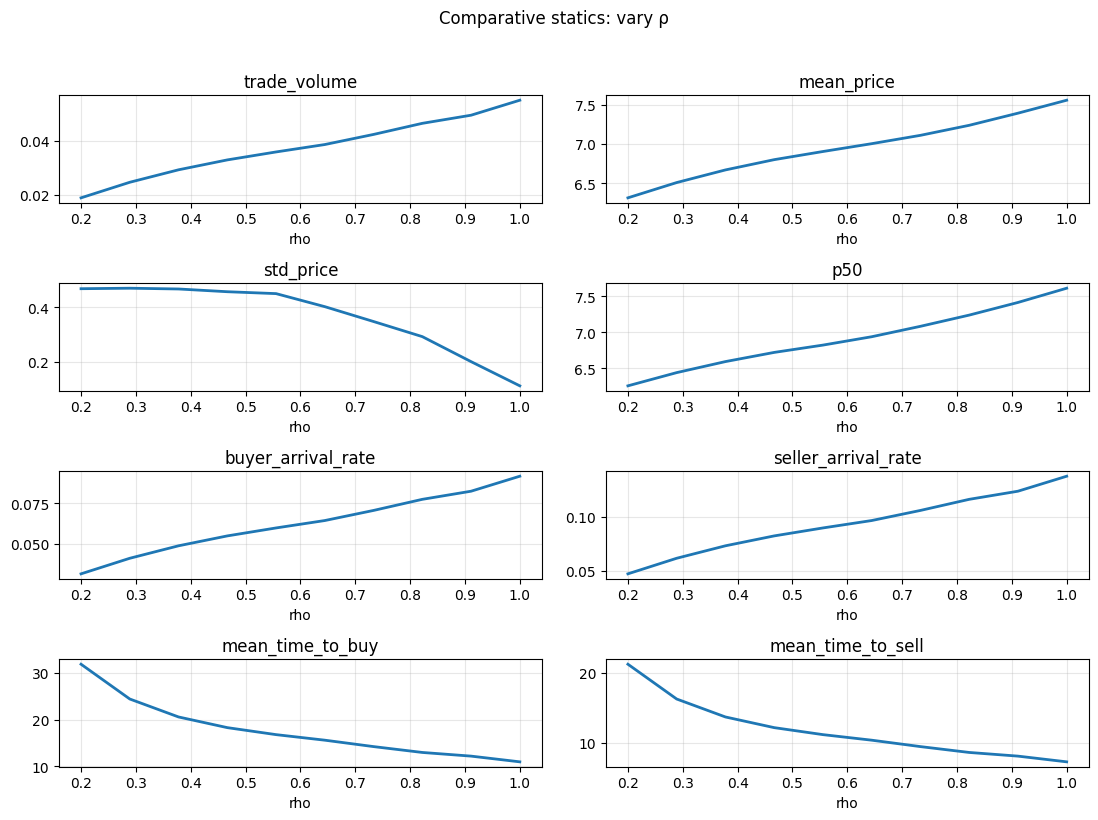

In [12]:
# %%
# Example: comparative statics over one parameter (8-plot moments panel)

if __name__ == "__main__":
    base = Params(
        r=0.05, gamma=0.20, rho=0.50, s=0.40,
        dmin=0.0, dmax=1.0, N=201,
        beta_a=2.0, beta_b=5.0,
        dt_hjb=25.0, dt_kfe=25.0,
        max_iter_inner=100, max_iter_outer=500,
        tol_V=1e-8, tol_h=1e-8
    )

    # Choose ONE sweep to run at a time
    grid_rho   = np.linspace(0.2, 1.0, 10)
    grid_gamma = np.linspace(0.05, 0.50, 10)
    grid_s     = np.linspace(0.20, 0.80, 10)

    t0 = time.perf_counter()
    res_rho = run_compstat_1d(
        base, "rho", grid_rho,
        moment_keys=MOMENT_KEYS_8PLOT,
        verbose=False
    )
    print(f"Comp stat over rho: {time.perf_counter()-t0:.2f}s")

    plot_compstat(res_rho, moment_keys=MOMENT_KEYS_8PLOT, ncols=2,
                  suptitle="Comparative statics: vary ρ")

    # To try gamma or s, comment rho lines above and use below:
    # res_gamma = run_compstat_1d(base, "gamma", grid_gamma, moment_keys=MOMENT_KEYS_8PLOT)
    # plot_compstat(res_gamma, moment_keys=MOMENT_KEYS_8PLOT, ncols=2, suptitle="Comparative statics: vary γ")
    #
    # res_s = run_compstat_1d(base, "s", grid_s, moment_keys=MOMENT_KEYS_8PLOT)
    # plot_compstat(res_s, moment_keys=MOMENT_KEYS_8PLOT, ncols=2, suptitle="Comparative statics: vary s")


In [ ]:
# %% [MD core — minimal from scratch]
import numpy as np
from dataclasses import replace
from scipy.optimize import minimize

# moments to match (must be produced by your compute_moments)
MD_KEYS = ["mean_price", "std_price", "trade_volume", "mean_time_to_sell"]

def _vec(d, keys):  # dict -> ordered vector
    return np.array([float(d[k]) for k in keys], dtype=float)

def _theta_from_phi(phi):
    """
    phi = (φ_rho, φ_gamma, φ_a, φ_b)
    rho    = exp(φ_rho)          ∈ (0, ∞)
    gamma  = exp(φ_gamma)        ∈ (0, ∞)
    a      = 1 + exp(φ_a)        ∈ (1, ∞)
    b      = 1 + exp(φ_b)        ∈ (1, ∞)
    """
    phi = np.asarray(phi, float)
    rho   = np.exp(phi[0])
    gamma = np.exp(phi[1])
    a     = 1.0 + np.exp(phi[2])
    b     = 1.0 + np.exp(phi[3])
    return np.array([rho, gamma, a, b], dtype=float)

def _phi_from_theta(theta):
    """
    inverse map; requires rho,gamma>0 and a,b>1.
    if you pass a,b ≤ 1 in theta0, this will raise.
    """
    theta = np.asarray(theta, float)
    rho, gamma, a, b = theta
    if (rho <= 0) or (gamma <= 0) or (a <= 1) or (b <= 1) or (not np.all(np.isfinite(theta))):
        raise ValueError("theta0 must satisfy rho>0, gamma>0, a>1, b>1 and be finite.")
    phi_rho   = np.log(rho)
    phi_gamma = np.log(gamma)
    phi_a     = np.log(a - 1.0)
    phi_b     = np.log(b - 1.0)
    return np.array([phi_rho, phi_gamma, phi_a, phi_b], dtype=float)


def build_md_objective(base_params, data_moments, W=None, mask=None, grid_N=None, eps=1e-8, verbose=True):
    """Return f(phi): MD loss at phi, with θ = exp(phi). Prints EVERY evaluation."""
    m_data_full = _vec(data_moments, MD_KEYS)
    if mask is None:
        mask = np.isfinite(m_data_full)
    mask = np.asarray(mask, bool)
    m_data = m_data_full[mask]

    if W is None:
        W = np.eye(m_data.size)
    else:
        W = np.asarray(W, float)
        if W.shape != (m_data.size, m_data.size):
            raise ValueError("W has wrong shape for selected moments.")

    eval_counter = {"n": 0}

    def f(phi):
        eval_counter["n"] += 1
        theta = _theta_from_phi(phi)           # (rho, gamma, a, b)
        rho, gamma, a, b = [float(x) for x in theta]

        # params copy (no warm starts, no tolerance tweaks)
        p = replace(base_params)
        if grid_N is not None:
            p.N = int(grid_N)
        p.rho, p.gamma, p.beta_a, p.beta_b = rho, gamma, a, b

        # solve model
        out = solve_stationary(p, warm=None, verbose=False)

        # model moments
        m_model_full = _vec(compute_moments(out, p), MD_KEYS)
        m_model = m_model_full[mask]

        # relative error with safe denom
        denom = np.maximum(np.abs(m_data), eps)
        rel = (m_model - m_data) / denom

        loss = float(rel.T @ (W @ rel))
        if verbose:
            print(f"[eval {eval_counter['n']:4d}] loss={loss: .6e} | "
                  f"rho={rho:.6f}, gamma={gamma:.6f}, a={a:.6f}, b={b:.6f}")
        # expose for callback
        f.last_loss = loss
        f.last_theta = theta
        f.n_eval = eval_counter["n"]
        return loss

    f.last_loss = np.nan
    f.last_theta = None
    f.n_eval = 0
    return f

def run_md(base_params, data_moments, theta0, *, W=None, mask=None, grid_N=None,
           method="Nelder-Mead", maxiter=200, maxfev=400, verbose=True):
    """Minimal driver: φ=log θ, Nelder–Mead, prints EVERY iteration via callback."""
    phi0 = _phi_from_theta(theta0)
    obj = build_md_objective(base_params, data_moments, W=W, mask=mask, grid_N=grid_N, verbose=verbose)

    it = {"k": 0}
    def cb(phik):
        it["k"] += 1
        th = _theta_from_phi(phik)
        best = getattr(obj, "last_loss", np.nan)
        if verbose:
            print(f"[iter {it['k']:3d}] best_so_far={best: .6e} | "
                  f"rho={th[0]:.6f}, gamma={th[1]:.6f}, a={th[2]:.6f}, b={th[3]:.6f}")

    res = minimize(
        obj, x0=phi0, method=method,
        callback=cb,
        options=dict(maxiter=maxiter, maxfev=maxfev, xatol=1e-6, fatol=1e-6, disp=False)
    )

    # map back to θ̂ and recompute moments once (clean)
    theta_hat = _theta_from_phi(res.x)
    p_hat = replace(base_params)
    p_hat.rho, p_hat.gamma, p_hat.beta_a, p_hat.beta_b = [float(x) for x in theta_hat]
    if grid_N is not None:
        p_hat.N = int(grid_N)
    out_hat = solve_stationary(p_hat, warm=None, verbose=False)
    M_hat = compute_moments(out_hat, p_hat)

    # attach small extras
    res.theta_hat = theta_hat
    res.n_eval = getattr(obj, "n_eval", None)
    res.n_iter = it["k"]
    res.last_logged = getattr(obj, "last_loss", np.nan)
    return res, p_hat, M_hat, out_hat


In [38]:
# %% [MD example run — Irish moments]
import numpy as np
import time
#rho=0.408321, gamma=0.468305, a=1.000000, b=1.446185
base =Params(
    r=0.0362, gamma=0.468305, rho=0.408321, s=0.6884,
    dmin=0.0, dmax=1.0, N=301,
    beta_a=1.000001, beta_b=1.446185,
    dt_hjb=25.0, dt_kfe=25.0,
    max_iter_inner=100, max_iter_outer=300,
    tol_V=1e-7, tol_h=1e-7
)
data_moments = {
    "mean_price": 11.42,
    "std_price":  4.0,
    "trade_volume": 0.02,
    "mean_time_to_sell": 1.0/0.0559,  # ≈ 17.88
}

W = None
mask = None
theta0 = np.array([0.408321, 0.468305, 1.000001, 1.446185], float)  # [rho, gamma, a, b]

t0 = time.perf_counter()
res, p_hat, M_hat, out_hat = run_md(
    base, data_moments, theta0,
    W=W, mask=mask, grid_N=201,
    method="Nelder-Mead",   # prints every eval + iteration
    maxiter=100, maxfev=300, verbose=True
)
print(f"\nMD wall time: {time.perf_counter()-t0:.2f} s")

print("\n=== MD results ===")
print(f"theta_hat: rho={res.theta_hat[0]:.6f}, gamma={res.theta_hat[1]:.6f}, "
      f"a={res.theta_hat[2]:.6f}, b={res.theta_hat[3]:.6f}")
print(f"objective: {res.fun:.6e} | last_logged: {res.last_logged:.6e}")
print(f"n_iter={res.n_iter}  n_eval={res.n_eval}  status='{res.message}'")

# compare moments in the MD order
def _sel(d): return np.array([d[k] for k in MD_KEYS], float)
mv = _sel(M_hat); dv = _sel(data_moments)
print("\nMoments (model vs data):")
for k, mvi, dvi in zip(MD_KEYS, mv, dv):
    print(f"{k:>18s} : {mvi:10.4f} | {dvi:10.4f}")


[eval    1] loss= 1.137022e+00 | rho=0.408321, gamma=0.468305, a=1.000001, b=1.446185
[eval    2] loss= 1.142176e+00 | rho=0.390438, gamma=0.468305, a=1.000001, b=1.446185
[eval    3] loss= 1.141890e+00 | rho=0.408321, gamma=0.450874, a=1.000001, b=1.446185
[eval    4] loss= 1.137022e+00 | rho=0.408321, gamma=0.468305, a=1.000001, b=1.446185
[eval    5] loss= 1.137729e+00 | rho=0.408321, gamma=0.468305, a=1.000001, b=1.428539
[eval    6] loss= 1.137873e+00 | rho=0.427023, gamma=0.459507, a=1.000001, b=1.437273
[iter   1] best_so_far= 1.137873e+00 | rho=0.408321, gamma=0.468305, a=1.000001, b=1.446185
[eval    7] loss= 1.137778e+00 | rho=0.417567, gamma=0.481819, a=1.000001, b=1.432884
[iter   2] best_so_far= 1.137778e+00 | rho=0.408321, gamma=0.468305, a=1.000001, b=1.446185
[eval    8] loss= 1.137886e+00 | rho=0.394834, gamma=0.484109, a=1.000001, b=1.439484
[eval    9] loss= 1.137141e+00 | rho=0.418738, gamma=0.465538, a=1.000001, b=1.437825
[iter   3] best_so_far= 1.137141e+00 | rho